In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample
from optic.plot import eyediagram
from optic.utils import parameters

# Cálculo da Densidade Espectral de Potência (DSP) de um Sinal em Banda Base

Este texto apresenta o cálculo da densidade espectral de potência (DSP) de um sinal modulador em banda base. Assumem-se símbolos independentes, equiprováveis e de média nula.

---

## Modelo do Sinal PAM em Banda Base

O sinal transmitido é modelado como:

$$
s(t) = \sum_{k=-\infty}^{\infty} a_k\, p(t - kT)
$$

onde:

- $a_k$ são símbolos transmitidos (variáveis aleatórias),
- $p(t)$ é o formato de pulso,
- $T$ é o tempo de símbolo.

Assumimos:

$$
\mathbb{E}[a_k] = 0,
\qquad
\mathbb{E}[a_k^2] = \sigma_a^2
$$

Os símbolos são independentes, portanto a autocorrelação discreta é:

$$
R_a[m] = \mathbb{E}[a_k\, a_{k+m}] =
\begin{cases}
\sigma_a^2, & m = 0 \\
0, & m \neq 0
\end{cases}
$$

A DSP da sequência discreta de símbolos é:

$$
S_a(f) = \frac{\sigma_a^2}{T}.
$$


## DSP do Sinal Transmitido

Como o sinal é gerado pela convolução da sequência com o pulso $p(t)$, o teorema de modulação de processos aleatórios fornece:

$$
S_s(f) = S_a(f)\, |P(f)|^2.
$$

Substituindo, obtém-se a expressão geral da DSP de um sinal modulado digitalmente transmitido em banda base:

$$
S_s(f) = \frac{\sigma_a^2}{T}\, |P(f)|^2.
$$

---

## Exemplo: Pulso Retangular

Considere o pulso

$$
p(t) = A, \quad 0 \le t \le T,
$$

que pode ser escrit na forma

$$
p(t) = A\,[u(t) - u(t - T)].
$$

Aplicando-se a transformada de Fourier, obtem-se

$$
P(f) = A\,T\, \mathrm{sinc}(fT)\, e^{-j\pi fT},
$$

e

$$
|P(f)|^2 = A^2 T^2\, \mathrm{sinc}^2(fT).
$$

Assim, a DSP resultante é dada por

$$
S_s(f) = \sigma_a^2\, A^2 T\, \mathrm{sinc}^2(fT).
$$

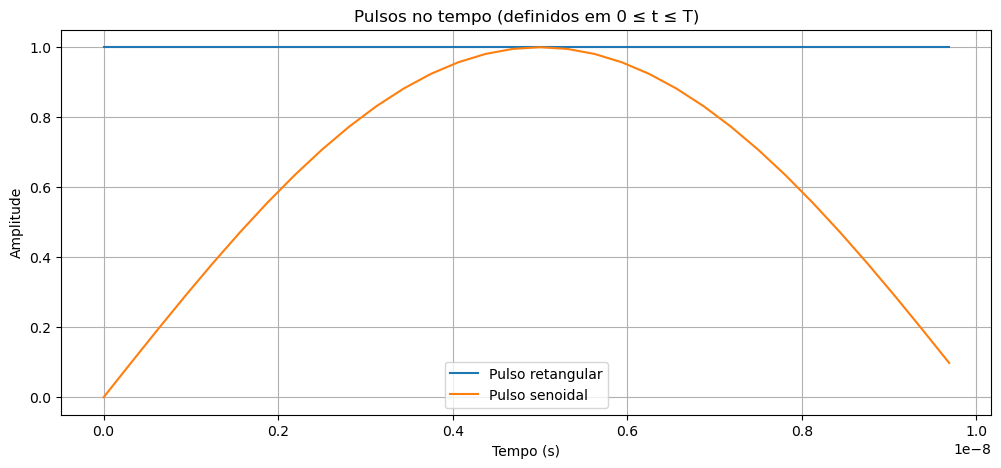

In [2]:
#----------------------------------------------------------------------------------
# Código que obtém e exibe a DSP de dois sinais com modulação PSK para dois pulsos:
# a) Retangular
# b) A*sin(πt/T)
#----------------------------------------------------------------------------------
        
SpS = 32
Rs  = 100e6
Fs  = Rs * SpS
Ts  = 1/Rs
Nsymb = 200000

# Definição dos pulsos
t = np.linspace(0, Ts, int(Ts*Fs), endpoint=False)
p_rect = np.ones_like(t)
p_sin = np.sin(np.pi * t / Ts)
plt.figure(figsize=(12,5))
plt.plot(t, p_rect, label='Pulso retangular')
plt.plot(t, p_sin, label='Pulso senoidal')
plt.title("Pulsos no tempo (definidos em 0 ≤ t ≤ T)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()

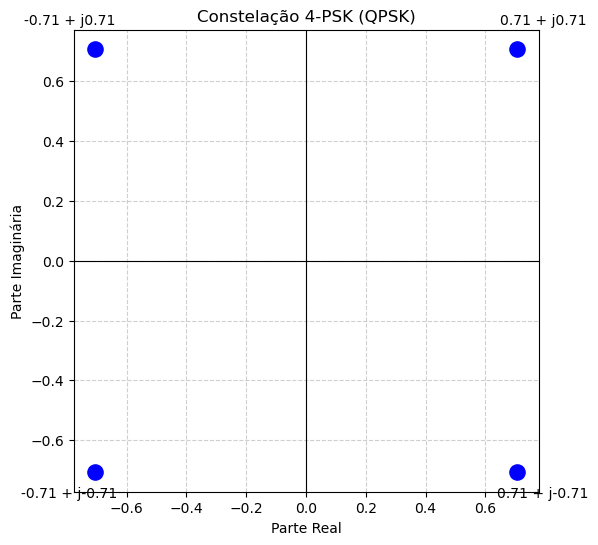

In [3]:
#-------------------------------------------------
# Símbolos modulação 4-PSK
#-------------------------------------------------

symbols = (1/np.sqrt(2)) * np.array([1+1j, 1-1j, -1+1j, -1-1j])
ak = np.random.choice(symbols, Nsymb)
ak_up = upsample(ak, SpS)

plt.figure(figsize=(6,6))
plt.scatter(np.real(symbols), np.imag(symbols), s=120, color='blue')

for s in symbols:
    plt.text(np.real(s)*1.12, np.imag(s)*1.12,
             f"{np.real(s):.2f} + j{np.imag(s):.2f}",
             fontsize=10, ha="center")

plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Constelação 4-PSK (QPSK)")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginária")
plt.axis('equal')
plt.show()

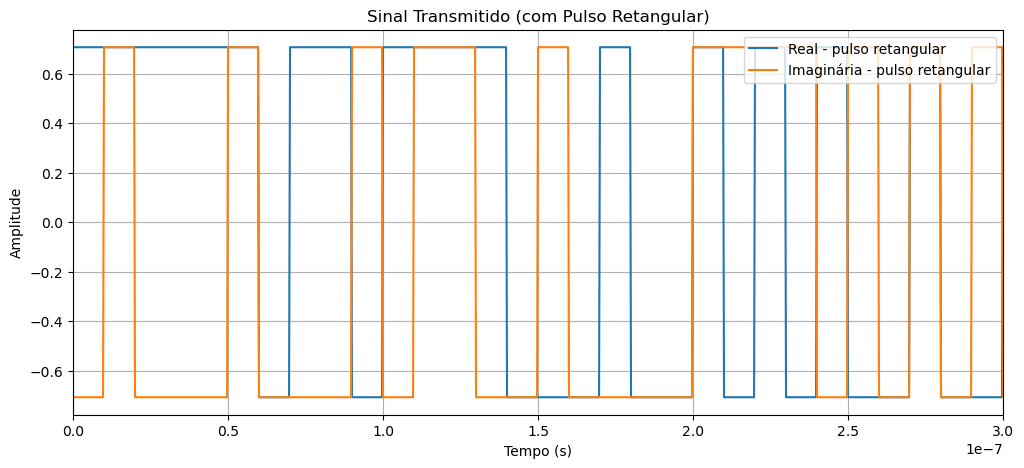

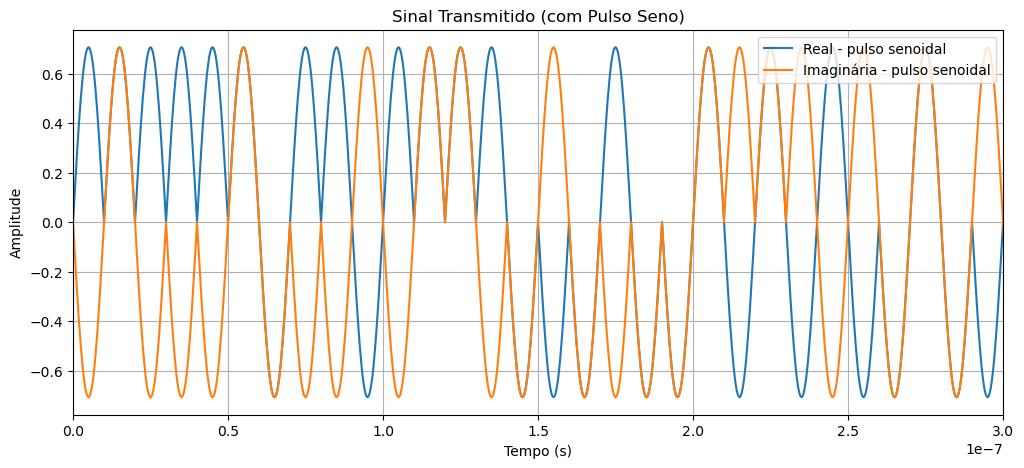

In [4]:
#-------------------------------------------------
# Formatação de pulso
#-------------------------------------------------

s_rect = np.convolve(ak_up, p_rect, mode='full')
s_sin  = np.convolve(ak_up, p_sin, mode='full')


t_sig = np.arange(len(s_rect)) / Fs

plt.figure(figsize=(12,5))
plt.plot(t_sig, np.real(s_rect), label='Real - pulso retangular')
plt.plot(t_sig, np.imag(s_rect), label='Imaginária - pulso retangular')
plt.title("Sinal Transmitido (com Pulso Retangular)")
plt.xlim(0, 300e-9)
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc ='upper right')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(t_sig, np.real(s_sin), label='Real - pulso senoidal')
plt.plot(t_sig, np.imag(s_sin), label='Imaginária - pulso senoidal')
plt.xlim(0, 300e-9)
plt.title("Sinal Transmitido (com Pulso Seno)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

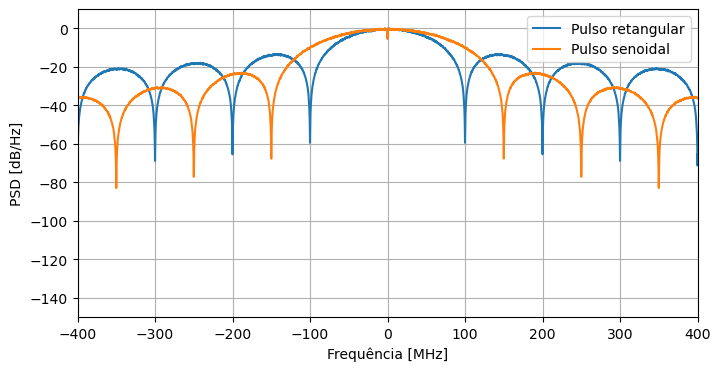

In [5]:
#-------------------------------------------------
# Densidade espectral de potência (PSD)
#-------------------------------------------------

f, P_rect = welch(s_rect, fs=Fs, nperseg=16384, return_onesided=False)
_, P_sin  = welch(s_sin,  fs=Fs, nperseg=16384, return_onesided=False)

f = np.fft.fftshift(f)
P_rect = np.fft.fftshift(P_rect)
P_sin  = np.fft.fftshift(P_sin)

P_rect_n = P_rect / np.max(P_rect)
P_sin_n  = P_sin  / np.max(P_sin)
idx_dc = np.argmin(np.abs(f))


f_pos = f[idx_dc:]
P_rect_pos = P_rect_n[idx_dc:]
P_sin_pos  = P_sin_n[idx_dc:]


plt.figure(figsize=(8,4))
plt.plot(f/1e6, 10*np.log10(P_rect_n), label='Pulso retangular')
plt.plot(f/1e6, 10*np.log10(P_sin_n),  label='Pulso senoidal')
plt.xlim(-400, 400)
plt.ylim(-150, 10)
plt.xlabel('Frequência [MHz]')
plt.ylabel('PSD [dB/Hz]')
plt.grid()
plt.legend()
plt.show()

---
A imagem ilustra a DSP dos sinais gerados a partir da formatação com ambos os pulsos, e é possível notar que o pulso senoidal ocupa mais banda que o pulso retangular ideal

In [6]:
#-------------------------------------------------
# Cálculo de f_3dB e do primeiro nulo
#-------------------------------------------------

def freq_3db(f, Pn):
    idx = np.where(np.abs(Pn)<= 0.5)[0][1]  # primeira ocorrência
    return abs(f[idx])

def first_null(f, Pn, threshold=-57):
    idx = np.where(10*np.log10(Pn) <= threshold)[0][0]
    return abs(f[idx])

f3db_rect = freq_3db(f_pos, P_rect_pos)
f3db_sin  = freq_3db(f_pos, P_sin_pos)

fnull_rect = first_null(f_pos, P_rect_pos)
fnull_sin  = first_null(f_pos, P_sin_pos)

print('--- Pulso Retangular ---')
print(f'f_3dB      = {f3db_rect:.2f} Hz')
print(f'1º nulo    = {fnull_rect:.2f} Hz')

print('\n--- Pulso Senoidal ---')
print(f'f_3dB      = {f3db_sin:.2f} Hz')
print(f'1º nulo    = {fnull_sin:.2f} Hz')

--- Pulso Retangular ---
f_3dB      = 40429687.50 Hz
1º nulo    = 100000000.00 Hz

--- Pulso Senoidal ---
f_3dB      = 53320312.50 Hz
1º nulo    = 149804687.50 Hz


---

---

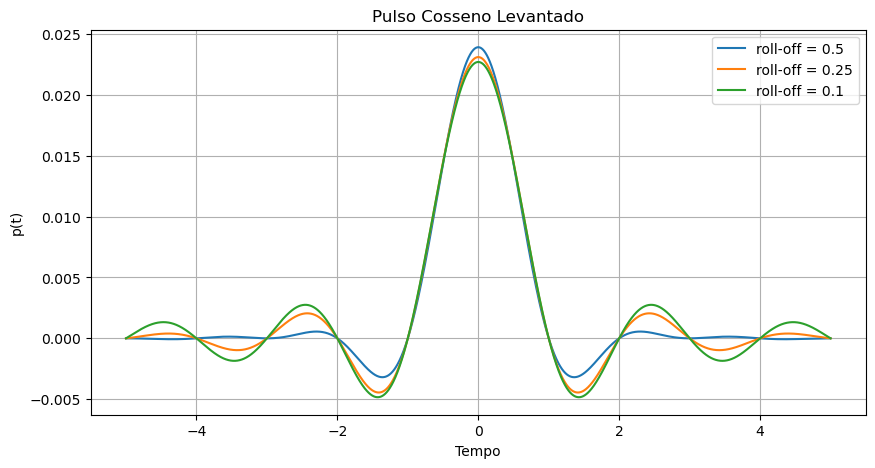

In [7]:
#-----------------------------------------------------------
# Este código gera os gráficos do pulso cosseno no tempo e
# plota os gráficos da transformada de Fourier dos pulsos
#-----------------------------------------------------------

Ts = 1.0
rolloffs = [0.5, 0.25, 0.1]

t = np.linspace(-5, 5, 20001)  
dt = t[1] - t[0]
Fs = 1/dt

def raised_cosine(t, Ts, alpha):
    p = np.zeros_like(t)

    for i, ti in enumerate(t):
        if ti == 0:
            p[i] = 1.0
        elif abs(ti) == Ts/(2*alpha):
            p[i] = (np.pi/4) * np.sinc(1/(2*alpha))
        else:
            num = np.sinc(ti/Ts) * np.cos(np.pi*alpha*ti/Ts)
            den = 1 - (2*alpha*ti/Ts)**2
            p[i] = num / den

    return p / np.sqrt(np.sum(p**2))

plt.figure(figsize=(10,5))

for alpha in rolloffs:
    p = raised_cosine(t, Ts, alpha)
    plt.plot(t, p, label=f'roll-off = {alpha}')

plt.xlabel('Tempo')
plt.ylabel('p(t)')
plt.title('Pulso Cosseno Levantado')
plt.grid()
plt.legend()
plt.show()


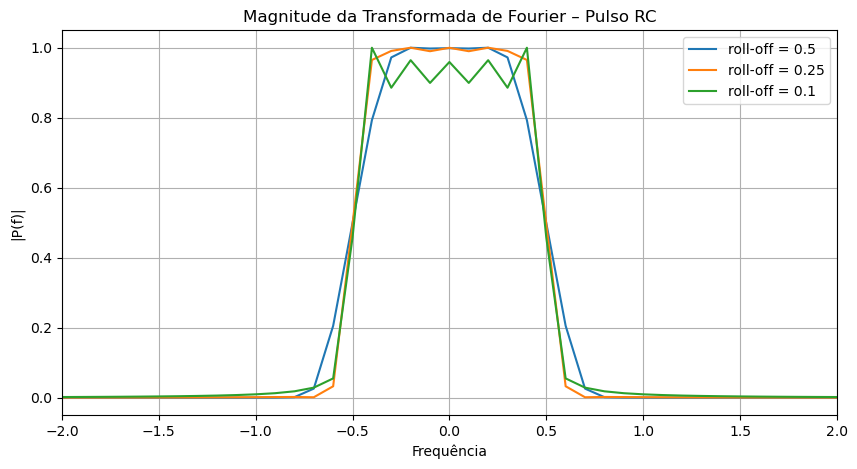

In [8]:
plt.figure(figsize=(10,5))

for alpha in rolloffs:
    p = raised_cosine(t, Ts, alpha)

    P = np.fft.fftshift(np.fft.fft(p))
    f = np.fft.fftshift(np.fft.fftfreq(len(t), d=dt))

    plt.plot(f, np.abs(P)/np.max(np.abs(P)), label=f'roll-off = {alpha}')

plt.xlim(-2, 2)
plt.xlabel('Frequência')
plt.ylabel('|P(f)|')
plt.title('Magnitude da Transformada de Fourier – Pulso RC')
plt.grid()
plt.legend()
plt.show()

---

---

# Atividade de Simulação

In [ ]:
def normalize_constellation(a):
    return a / np.sqrt(np.mean(np.abs(a)**2))

def generate_4pam(N):
    symbols = np.array([-3, -1, 1, 3])
    a = np.random.choice(symbols, N)
    return normalize_constellation(a)

def generate_qpsk(N):
    symbols = np.array([1+1j, 1-1j, -1+1j, -1-1j])
    a = np.random.choice(symbols, N)
    return normalize_constellation(a)

def generate_16qam(N):
    re = np.array([-3, -1, 1, 3])
    im = np.array([-3, -1, 1, 3])
    symbols = np.array([x + 1j*y for x in re for y in im])
    a = np.random.choice(symbols, N)
    return normalize_constellation(a)

def pulse_rect(SpS):
    p = np.ones(SpS)
    return p / np.sqrt(np.sum(p**2))

def pulse_raised_cosine(SpS, alpha, span=8):
    t = np.arange(-span*SpS, span*SpS + 1) / SpS
    p = np.zeros_like(t)

    for i, ti in enumerate(t):
        if ti == 0:
            p[i] = 1.0
        elif alpha != 0 and np.isclose(abs(ti), 1/(2*alpha)):
            p[i] = (np.pi/4) * np.sinc(1/(2*alpha))
        else:
            num = np.sinc(ti) * np.cos(np.pi * alpha * ti)
            den = 1 - (2 * alpha * ti)**2
            p[i] = num / den

    return p / np.sqrt(np.sum(p**2))


def periodogram(sig, Fs):
    N = len(sig)
    S = np.fft.fftshift(np.fft.fft(sig))
    f = np.fft.fftshift(np.fft.fftfreq(N, 1/Fs))
    P = (np.abs(S)**2) / (Fs*N)
    return f, P

def BB_signal(a, pulse, SpS):
    up = np.zeros(len(a)*SpS, dtype=complex)
    up[::SpS] = a
    s = np.convolve(up, pulse, mode='full')
    return s

def bandwidth_99(f, P):
    df = f[1] - f[0]

    power_total = np.sum(P) * df

    idx0 = np.argmin(np.abs(f))
    power_acc = 0.0

    k = 0
    while power_acc < 0.99 * power_total:
        if idx0 - k < 0 or idx0 + k >= len(P):
            break
        power_acc += (P[idx0 - k] + P[idx0 + k]) * df
        k += 1

    B99 = abs(f[idx0 + k])
    return B99



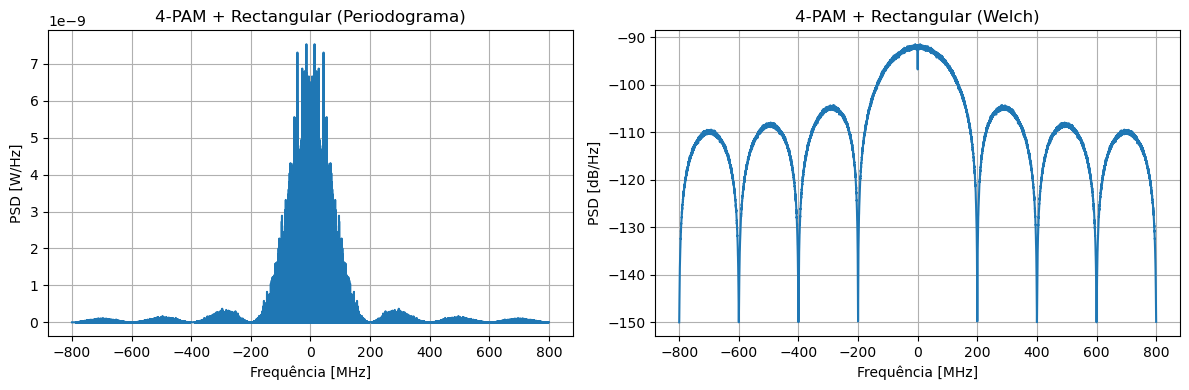

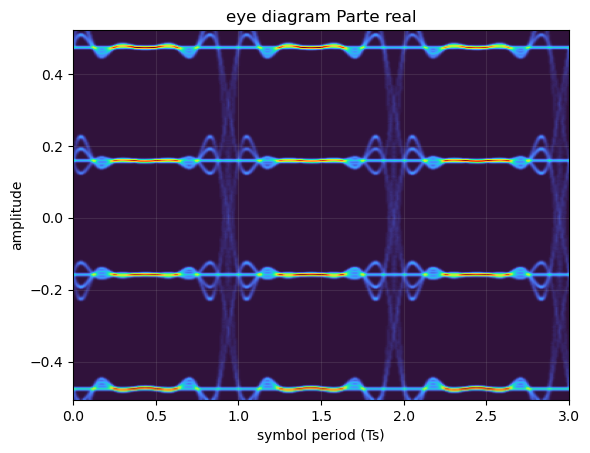

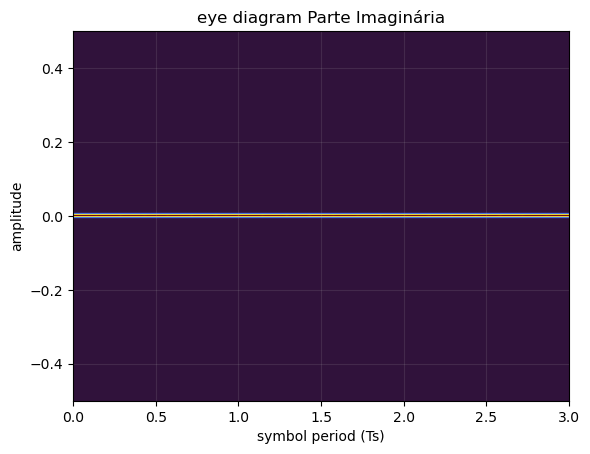

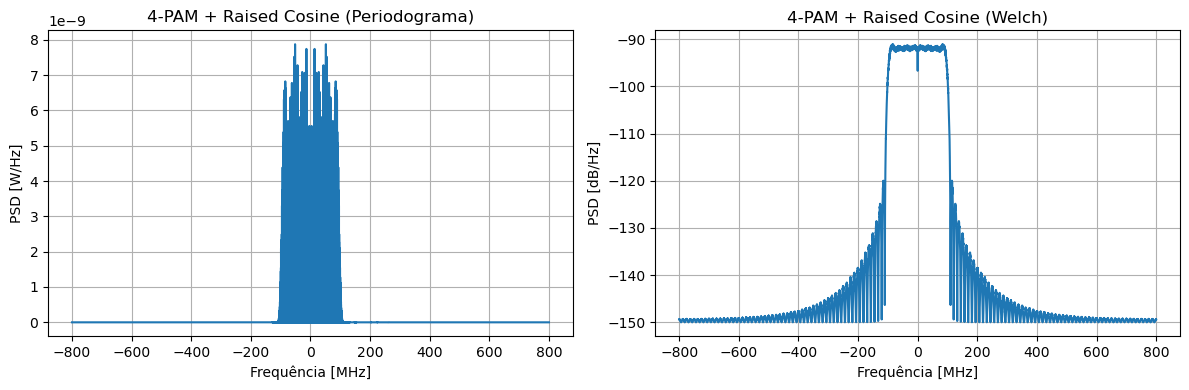

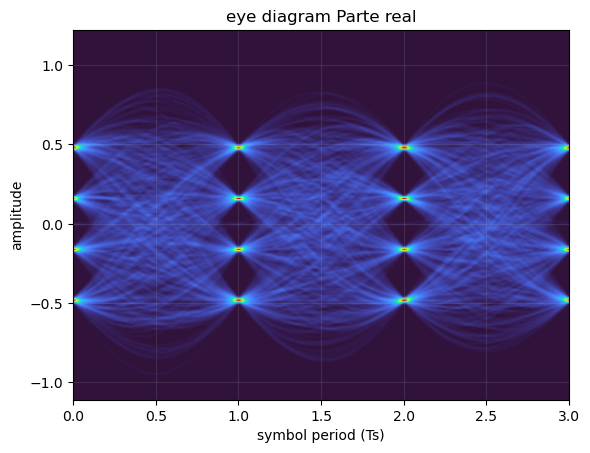

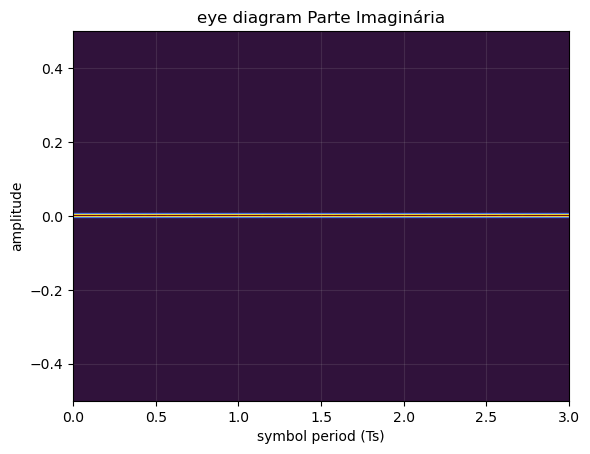

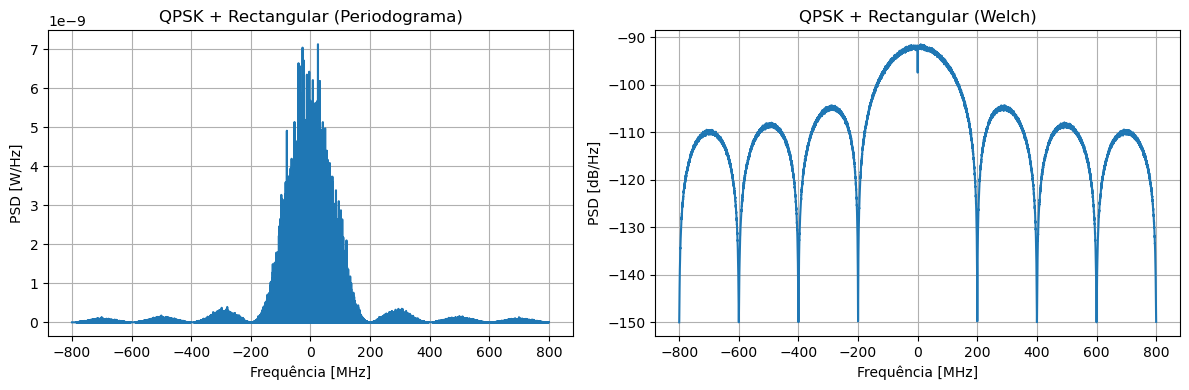

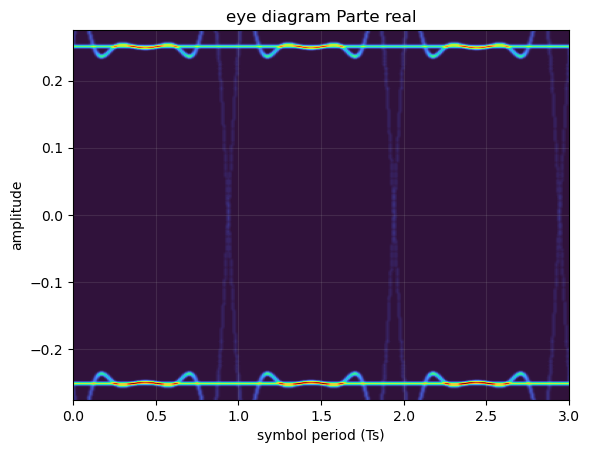

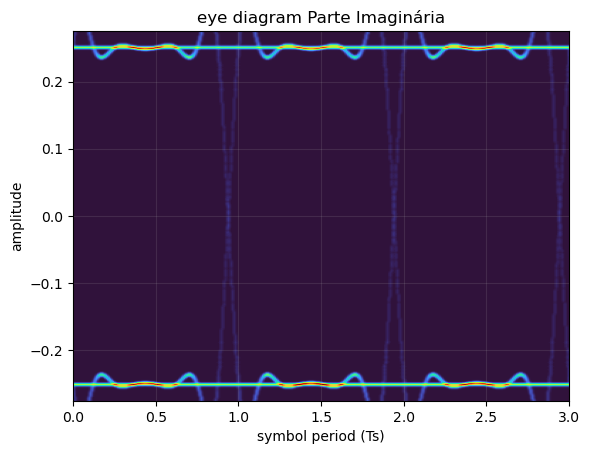

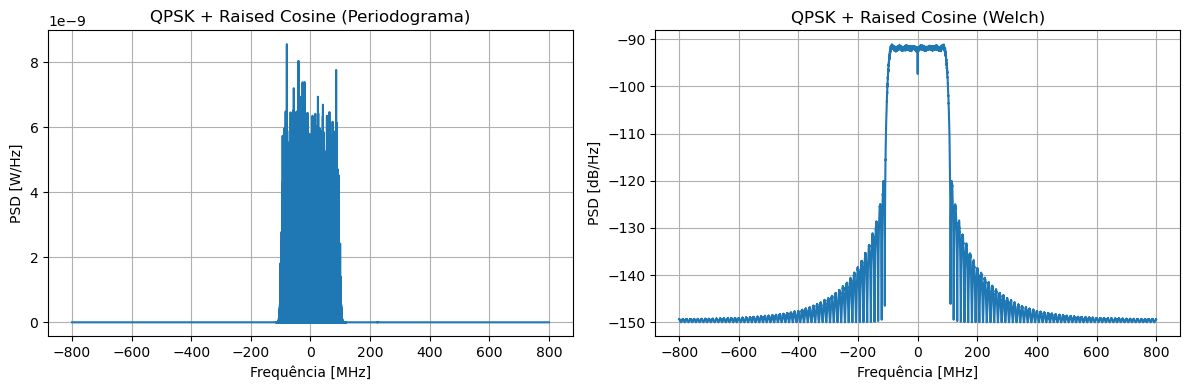

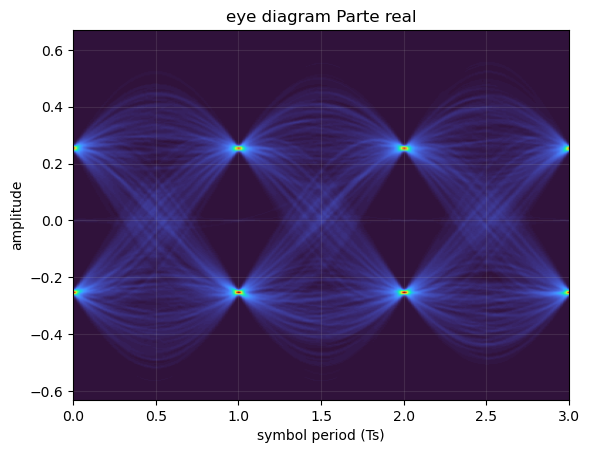

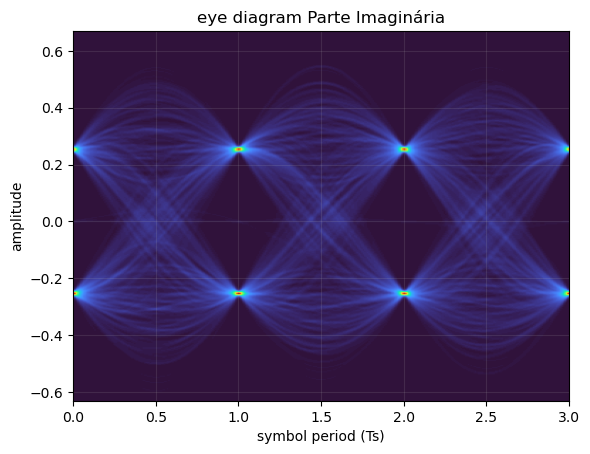

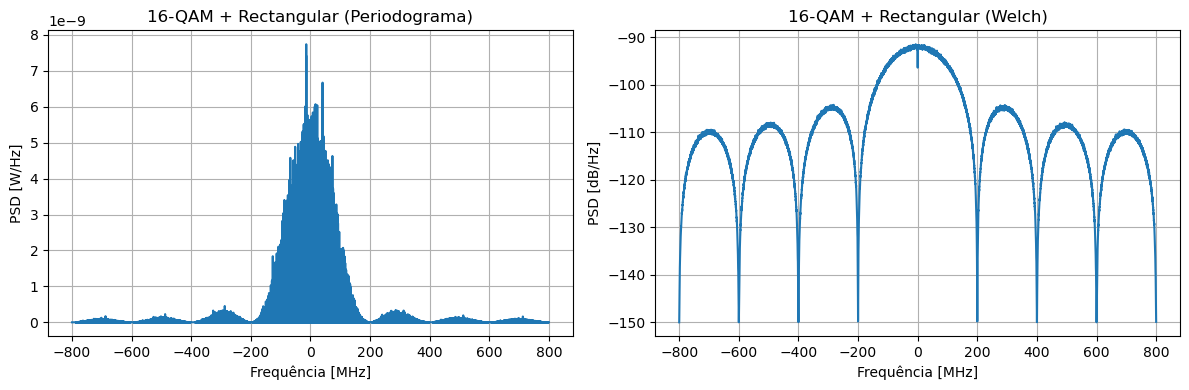

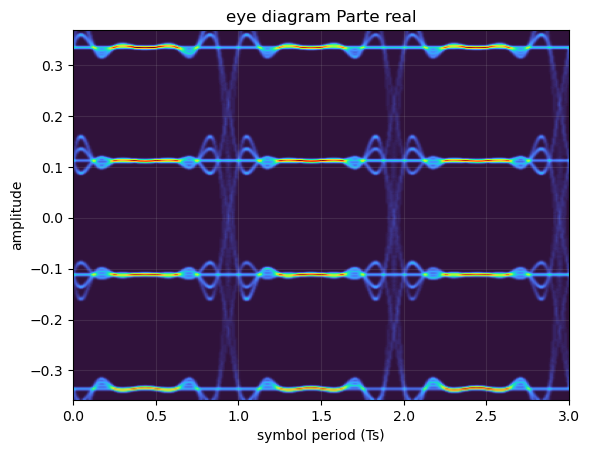

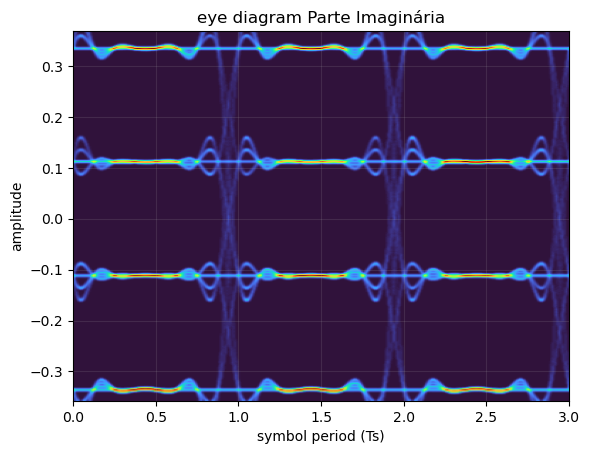

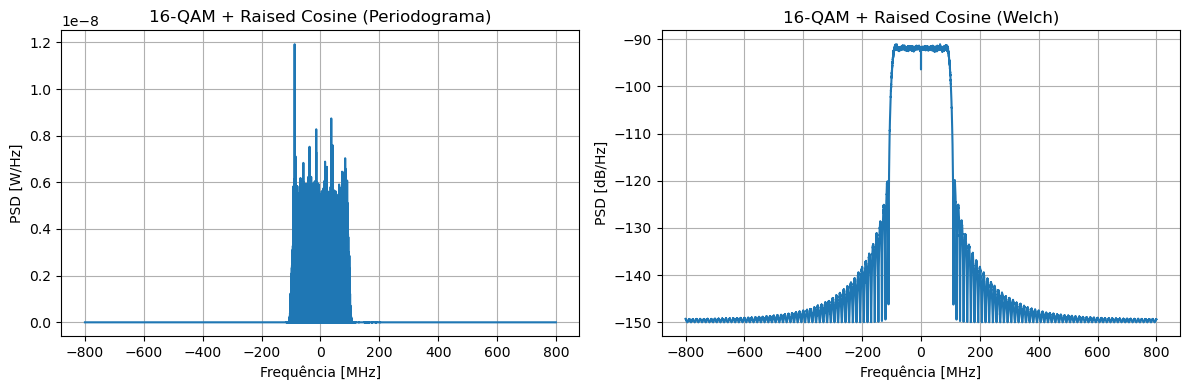

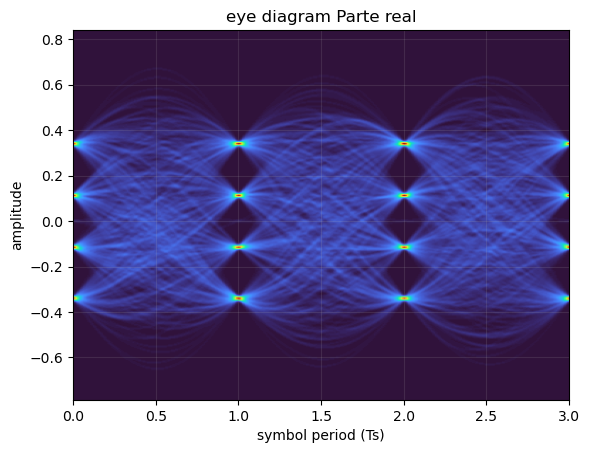

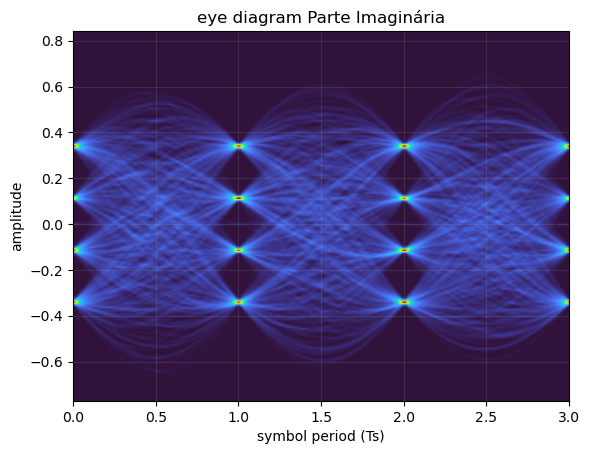

In [19]:
Rs = 200e6
Ts = 1/Rs
SpS = 8
Fs = Rs * SpS  
N = 500000
alphas = [0.01, 0.1, 0.5, 1.0]
modulations = {
    '4-PAM' : generate_4pam,
    'QPSK'  : generate_qpsk,
    '16-QAM': generate_16qam
}

pulses = {
    'Rectangular' : lambda: pulse_rect(SpS),
    'Raised Cosine': lambda: pulse_raised_cosine(SpS, alphas[1])
}
for mod_name, mod_fun in modulations.items():

    ak = mod_fun(N)

    for pulse_name, pulse_fun in pulses.items():

        p = pulse_fun()
        s = BB_signal(ak, p, SpS)

        # Periodograma
        S = np.fft.fftshift(np.fft.fft(s))
        f = np.fft.fftshift(np.fft.fftfreq(len(s), 1/Fs))
        P_per = np.abs(S)**2 / (Fs * len(s))

        # Welch
        fw, P_welch = welch(
            s, fs=Fs, nperseg=16384, return_onesided=False
        )
        fw = np.fft.fftshift(fw)
        P_welch = np.fft.fftshift(P_welch)

        plt.figure(figsize=(12,4))

        plt.subplot(1,2,1)
        plt.plot(f/1e6, P_per)
        plt.title(f'{mod_name} + {pulse_name} (Periodograma)')
        plt.xlabel('Frequência [MHz]')
        plt.ylabel('PSD [W/Hz]')
        plt.grid()

        plt.subplot(1,2,2)
        plt.plot(fw/1e6, 10*np.log10(P_welch + 1e-15))
        plt.title(f'{mod_name} + {pulse_name} (Welch)')
        plt.xlabel('Frequência [MHz]')
        plt.ylabel('PSD [dB/Hz]')
        plt.grid()

        plt.tight_layout()
        plt.show()
        eyediagram(np.real(s), len(s), SpS, ptype = 'fancy', plotlabel= 'Parte real')
        eyediagram(np.imag(s), len(s), SpS, ptype= 'fancy', plotlabel= 'Parte Imaginária')




---
Nas figuras, pode ser visto como a DSP de sinais formatados com o pulso cosseno levantado ocupa uma banda muito mais reduzida. Além disso, é possível notar nas imagens de diagramas de olho, como há oscilações nas bordas dos níveis de amplitude do sinal para o pulso retangular, evidenciando o efeito de Gibbs, devido à limitação de banda para um pulso retangular ideal na simulação.

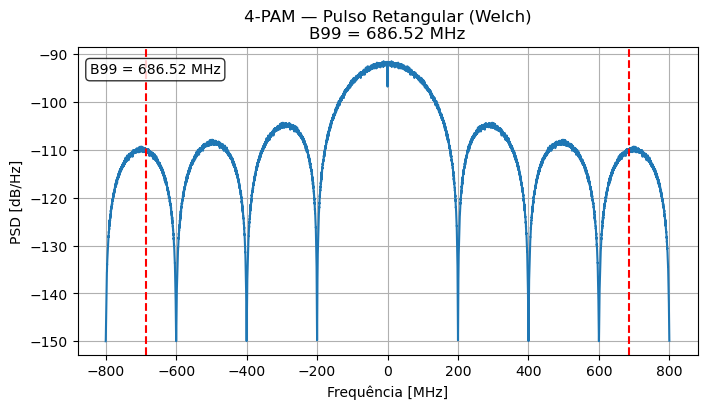

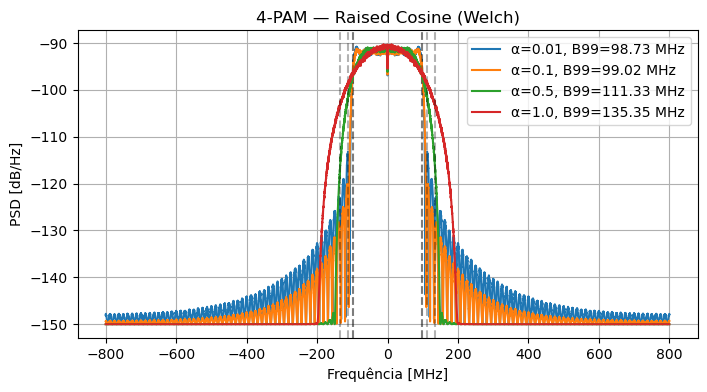

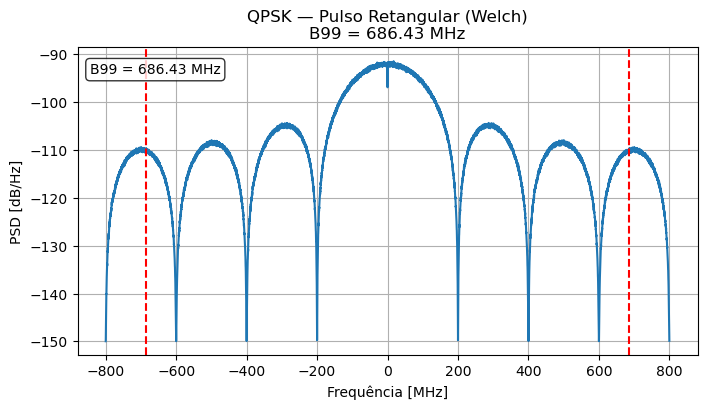

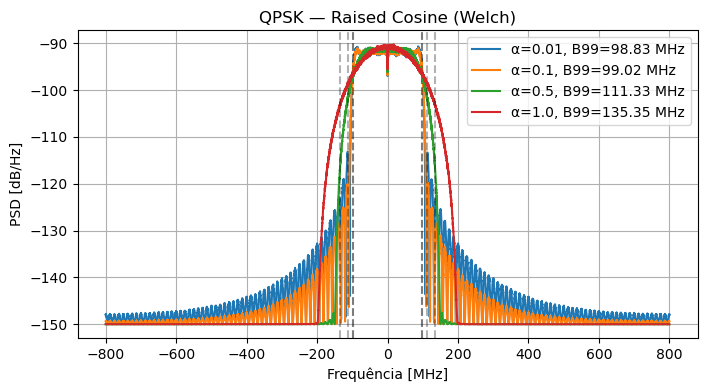

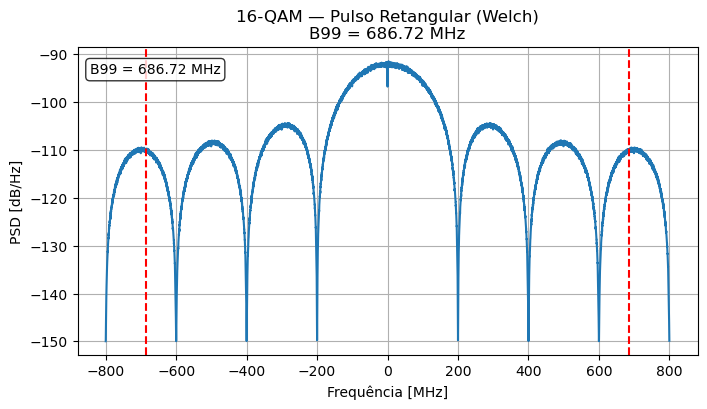

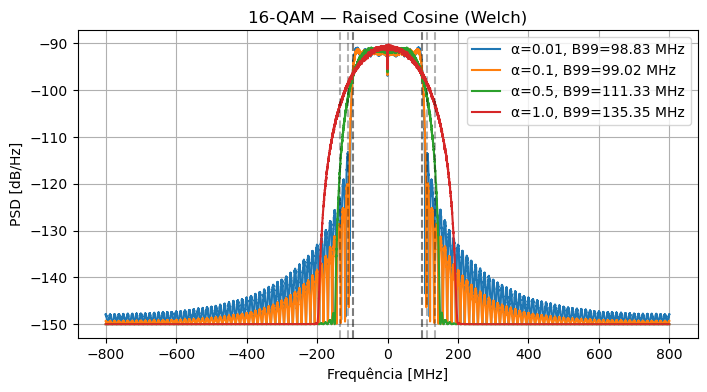

In [ ]:
for mod_name, mod_fun in modulations.items():

    ak = mod_fun(N)

    # ==============================
    # Pulso retangular
    # ==============================
    p_rect = pulse_rect(SpS)
    s_rect = BB_signal(ak, p_rect, SpS)

    f_rect, P_rect = welch(
        s_rect, fs=Fs, nperseg=16384, return_onesided=False
    )
    f_rect = np.fft.fftshift(f_rect)
    P_rect = np.fft.fftshift(P_rect)

    B99_rect = bandwidth_99(f_rect, P_rect)

    plt.figure(figsize=(8,4))
    plt.plot(f_rect/1e6, 10*np.log10(P_rect + 1e-15))
    plt.axvline( B99_rect/1e6, color='r', linestyle='--')
    plt.axvline(-B99_rect/1e6, color='r', linestyle='--')

    plt.title(
        f'{mod_name} — Pulso Retangular (Welch)\n'
        f'B99 = {B99_rect/1e6:.2f} MHz'
    )

    plt.text(
        0.02, 0.95,
        f'B99 = {B99_rect/1e6:.2f} MHz',
        transform=plt.gca().transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    plt.xlabel('Frequência [MHz]')
    plt.ylabel('PSD [dB/Hz]')
    plt.grid()
    plt.show()

    # ==============================
    # Pulso Raised Cosine
    # ==============================
    plt.figure(figsize=(8,4))

    for alpha in alphas:
        p_rc = pulse_raised_cosine(SpS, alpha)
        s_rc = BB_signal(ak, p_rc, SpS)

        f_rc, P_rc = welch(
            s_rc, fs=Fs, nperseg=16384, return_onesided=False
        )
        f_rc = np.fft.fftshift(f_rc)
        P_rc = np.fft.fftshift(P_rc)

        B99_rc = bandwidth_99(f_rc, P_rc)

        plt.plot(
            f_rc/1e6,
            10*np.log10(P_rc + 1e-15),
            label=f'α={alpha}, B99={B99_rc/1e6:.2f} MHz'
        )

        plt.axvline( B99_rc/1e6, color='k', linestyle='--', alpha=0.3)
        plt.axvline(-B99_rc/1e6, color='k', linestyle='--', alpha=0.3)

    plt.title(f'{mod_name} — Raised Cosine (Welch)')
    plt.xlabel('Frequência [MHz]')
    plt.ylabel('PSD [dB/Hz]')
    plt.legend()
    plt.grid()
    plt.show()


---

É possível notar pelas figuras dos espectros que a banda que acomoda 99% da potÊncia do sinal para o caso retangular é muito alta, aproximando-se de 700 MHZ. No caso do pulso raised-cosine, esse valor reduz consideravelmente, e apresenta diferenças a depender do fator de roll-off do pulso. Quanto maior o fator de roll-off, mais rápido ocorre o decrescimento do pulso no tempo, e consequentemente, ocupa mais banda, de modo que para valores maiores de $\alpha$, maior é a banda que comporta 99% da potência do sinal.